In [1]:
import sys,os
import numpy as np
import pandas as pd
import random
import math
from time import time
from datetime import datetime

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
### Binarization Step Parameters ###
bin_method = "GMM" # binarization method should be "GMM" or "Jenks"
pval = 0.001
min_n_samples = -1 # define authomatically if -1

### Feature clustering parameters ###
clust_method = "Louvain" # feature clustering method "WGCNA" or "DESMOND"

if clust_method == "Louvain":
    r = 1/3

if clust_method == "WGCNA":
    p1 = 10 # power for correlation matrix [1-30]
    p2 = 10 # power for tree cutof height 
    
if clust_method == "DESMOND":
    # PGM parameters
    alpha = 10.0 
    beta_K = 1.0

    # convergence
    max_n_steps= 50
    n_steps_for_convergence = 10

# seed - makes sense only for GMM and DESMOND - TBD
seed = 975987923


### input and output  ###

verbose = True
plot_all = True

# whether to load and to save binarized data
load = False
save = True



# Inputs:

 * z-score normalized gene expressions: 
      - tab-separated (.tsv) file with gene names in rows and sample/patient names in columns
      - row means should be 0, row std. = 1
    
# Outputs:
 * saves outputs to out_dir
 * binarized up- and donw- regulated genes: 
     - [basename].[GMM|Jenks].binarized_UP.tsv
     - [basename].[GMM|Jenks].binarized_DOWN.tsv
 * if binarization method is WGCNA, the results of WGCNA run are saved:
     - [basename].[GMM|Jenks].binarized_UP.modules.tsv
     - [basename].[GMM|Jenks].binarized_DOWN.modules.tsv
 * a table with biclusters: 
     - [basename].bin=[GMM|Jenks],clust=[WGCNA|DESMOND].biclusters.tsv


In [3]:
out_dir = os.getcwd()+"/tmp_results/"
basename = "METABRIC"  # "OV244" #"METABRIC" #  #   "TCGA-BRCA" 

data_dir = "/home/olya/TUM/DESMOND/datasets_DESMOND2/"
# z-normalized expressions 
# "OV_norm_counts.log2.z.tsv" "TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv" "METABRIC_1904_14K.nolog2_exprs_z.tsv"
exprs_file = data_dir + "METABRIC_1904_14K.nolog2_exprs_z.tsv"

In [6]:
from method import validate_input_matrix
start_time = time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
if verbose:
    print("Save output files to:",out_dir + basename + "*", file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

# downsampling
#np.random.seed(seed)
#ndxs = sorted(list(set(np.random.choice(range(0,1904),200))))
#exprs = exprs.iloc[:,ndxs]
#print(exprs.shape)

#check if z-score transformed (mean=0, std =1)
if not validate_input_matrix(exprs):
    print("Centering mean to 0 and std to 1",file= sys.stderr)
    m = exprs.mean(axis=1)
    std = exprs.std(axis=1)
    exprs = exprs.T-m
    exprs = exprs.T
    exprs = exprs.T/std
    exprs = exprs.T
# TBD:
#  - check missing values
#  - check min. samples: x < 40 - warning, x<=10 makes no sense 

# define minimal number of samples
if min_n_samples == -1:
    min_n_samples = round(min(0.5*exprs.shape[1],max(10,0.01*exprs.shape[1])))
if verbose:
    print("Mininal number of samples in a bicluster:",min_n_samples ,file=sys.stdout)
if min_n_samples < 10:
    print("min_n_samples is recommended to be >= 10", file= sys.stderr)

Save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/METABRIC*
Mininal number of samples in a bicluster: 19


In [7]:
exprs.mean(axis=1).abs().mean(), exprs.std(axis=1).abs().mean()

(6.306341835086247e-17, 1.0002627085291522)

# 1) Binarize individual features

### Find the trend between SNR and bicluster size

1) for all sizes [min_n_samples, int(N/2)+ min_n_samples], generate splits of random samples drawn from normal distributions

2) find SNR_thr(size) for a p-value cutoff, e.g. p_val =0.01 or 0.001; get_snr_thr is a function of bicluser size 


### Binarize expressions:

 * Jenks or GMM binarization
 * filtering by sample nubmer and SNR
     - n_samples =< min_n_samples, and
     - SNR > SNR_thr(n_samples)

In [8]:
from method import binarize

# some exmaple genes
show_fits = [ "FOXA1","ESR1","GATA3","ERBB2",'APOBEC3A',"PIK3R2","ENSG00000235023"] + ["ENSG00000107485",  "ENSG00000101000",  "ENSG00000197380",  
         "ENSG00000167779",  "ENSG00000105928",  "ENSG00000097033", 
         "ENSG00000148734",  "ENSG00000196581"] + ["ENSG00000134184","ENSG00000183793","ENSG00000278704"] + ["BCL2L2","CDK9","SPOCK3","SIRT6","ZNF415"]
#+["AIFM1","BRINP3","CATSPERB","CLCA2","CXCL17","CYP4Z2P","DNASE1","DUSP10"]

In [9]:
show_genes = list(pd.read_csv("/home/olya/UHH/OV cancer/report_3/44genes.txt",header=None)[0].values)


Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 1904,
		number of samples in a bicluster: 19 - 952,
		n_permutations: 5000
snr_pval threshold: 0.001
			fraction: 0.02
	SNR thresholds for individual features computed in 947.46 seconds
	GMM method is chosen ...
		genes processed: 0
Gene APOBEC3A: SNR=1.43, pos=259, neg=0


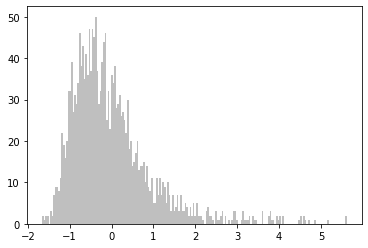

		genes processed: 1000
Gene BCL2L2: SNR=0.6, pos=0, neg=348


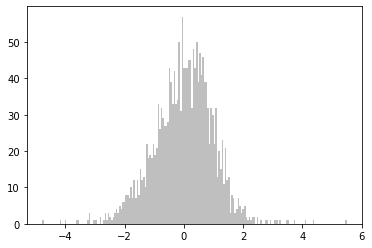

		genes processed: 2000
Gene CDK9: SNR=0.3, pos=362, neg=0


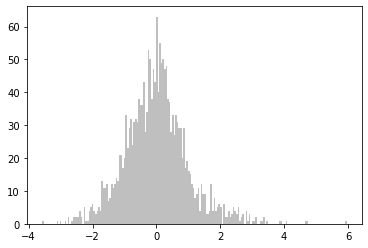

		genes processed: 3000
		genes processed: 4000
Gene ERBB2: SNR=2.42, pos=218, neg=0


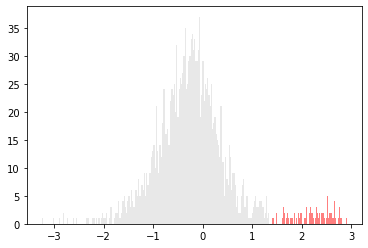

Gene ESR1: SNR=2.63, pos=0, neg=442


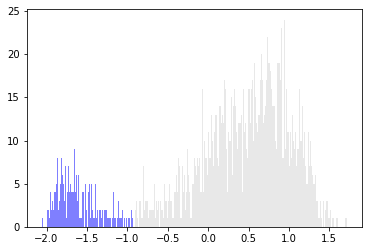

Gene FOXA1: SNR=2.85, pos=0, neg=253


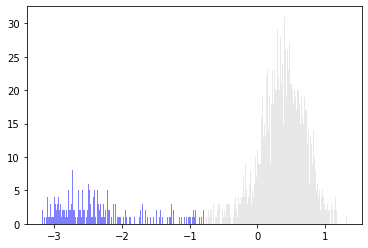

Gene GATA3: SNR=1.88, pos=0, neg=449


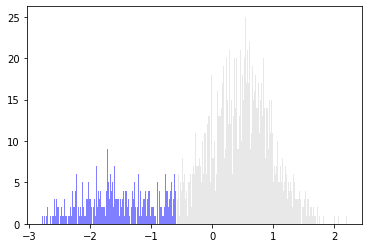

		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
Gene PIK3R2: SNR=1.25, pos=770, neg=0


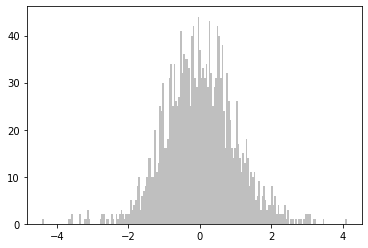

		genes processed: 10000
		genes processed: 11000
Gene SIRT6: SNR=0.74, pos=333, neg=0


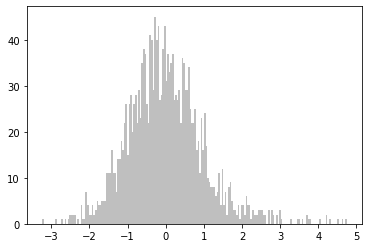

		genes processed: 12000
Gene SPOCK3: SNR=1.24, pos=915, neg=0


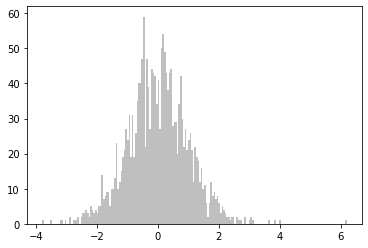

		genes processed: 13000
		genes processed: 14000
Gene ZNF415: SNR=1.47, pos=0, neg=361


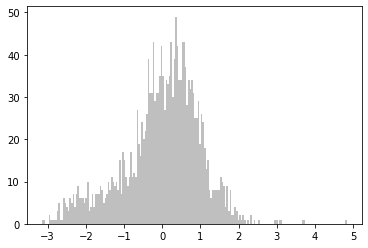

	GMM binarization for 14986 features completed in 274.27 s
	binarization runtime: 1221.74 s
	895 features passed binarization 
		UP-regulated features:	626
		DOWN-regulated features:	283
		ambiguous features:	14
Statistics is saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//METABRIC.GMM.binarization_stats.tsv
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//METABRIC.GMM.binarized_UP.tsv
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//METABRIC.GMM.binarized_DOWN.tsv


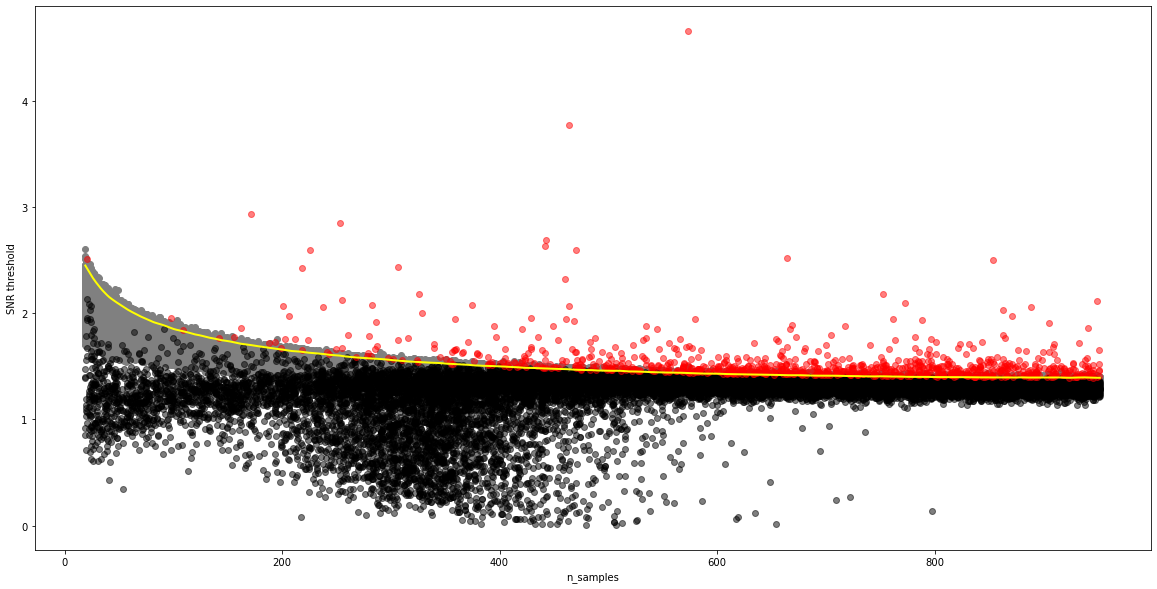

In [10]:
binarized_expressions,stats,empirical_snr = binarize(out_dir+"/"+basename, exprs=exprs,
                                 method=bin_method, save = save, load=load,
                                 min_n_samples = min_n_samples,pval=pval,
                                 plot_all = plot_all,show_fits = show_fits,
                                 verbose= verbose,seed=seed)
    

In [11]:
#stats.loc[show_genes,:].loc[stats['SNR']>stats['SNR_threshold'],:].shape

# Step 2. Group features into modules

Input: binarized inputs
Output: modules - sets of features with the same 1/0 profiles

 - feature clustering: choose WGCNA or DESMOND 
 - runs for up- and down-regulated features separately
 



###    WGCNA:

In [12]:
#clust_method = "WGCNA"
if clust_method == "WGCNA":
    from method import run_WGCNA
    
    clustering_results = {}
    for d in ["UP","DOWN"]:
        fname = out_dir+"/"+basename+ "."+bin_method+".binarized_"+d +".tsv"
        clustering_results[d] = run_WGCNA(fname,p1=p1,p2=p2, verbose = verbose)

## Louvain

In [13]:
#J = 1/3
clust_method = "Louvain"
if clust_method == "Louvain":
    from method import run_Louvain, get_similarity_corr
    
    clustering_results = {}
    for d in ["UP","DOWN"]:
        similarity = get_similarity_corr(binarized_expressions[d],r = r)
        clustering_results[d] = run_Louvain(similarity, verbose = True) 
        #similarity2 = get_similarity_jaccard(binarized_expressions[d],J=J,qval = 0.01)
        #clustering_results[d] = run_Louvain(similarity2, verbose = True) 
        

	 modules: 19 not_clustered: 207
		modularity: 0.667 runtime: 0.02 s
	 modules: 13 not_clustered: 66
		modularity: 0.248 runtime: 0.01 s


## Markov Clustering

In [14]:
#clust_method = "MCL"
if clust_method == "MCL":
    from method import run_MCL, get_similarity
    r =0.33
    for d in ["UP","DOWN"]:
        print(d)
        similarity = get_similarity(binarized_expressions[d],r = r)
        clustering_results[d] = run_MCL(similarity, r = r)#, inflations=inflations)

### DESMOND:

In [15]:
#clust_method = "DESMOND"
if clust_method == "DESMOND":
    from pgm import run_sampling
    # PGM parameters
    alpha = 2.0 # convergence fails from 0.25; 0.33 is still Ok
    beta_K = 1

    # convergence
    max_n_steps= 50
    n_steps_averaged = 10
    n_points_fit=10
    n_steps_for_convergence = 10

    clustering_results ={}
    for d in ["UP","DOWN"]:
        exprs_bin = binarized_expressions[d]
        genes = exprs_bin.columns.values
        clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.51,
                    max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                    n_points_fit = n_points_fit, tol = 0.1,
                    n_steps_for_convergence = n_steps_for_convergence,
                    verbose =True,plot_all=plot_all)

# 3. K-means to split modules into biclusters and background

In [16]:
from method import make_biclusters 
#from method import modules2biclusters, run_2means,add_SNR_to_biclusters



In [17]:
from method import make_biclusters 
filtered_bics = make_biclusters(clustering_results,binarized_expressions,exprs,
                                min_n_samples=min_n_samples, min_n_genes=2,
                                seed = seed,
                                save=True, out_dir=out_dir,basename=basename,
                                bin_method=bin_method,clust_method=clust_method)

filtered_bics.loc[filtered_bics["n_genes"]>2,:]

(19, 9)
(13, 9)
/home/olya/TUM/DESMOND/DESMOND2/tmp_results/METABRIC.bin=GMM,clust=Louvain.biclusters.tsv


,gene_ids,n_genes,sample_ids,n_samples,avgSNR,direction,genes,samples
1,"{268, 269, 270, 271, 272}",5,"{7, 18, 21, 28, 36, 46, 50, 51, 53, 58, 59, 63...",338,1.502066,UP,"{HOXB4, HOXB3, HOXB5, HOXB-AS3, HOXB6}","{MB-7026, MB-5418, MB-4688, MB-4991, MB-0654, ..."
3,"{549, 360, 366, 430, 462, 177, 241, 244, 415}",9,"{1536, 513, 1027, 1031, 1032, 522, 1547, 13, 1...",247,1.406142,UP,"{MIEN1, MBD4, GSDMB, PGAP3, STARD3, PSMD3, GRB...","{MB-4724, MB-3488, MB-5166, MB-5418, MB-0046, ..."
8,"{162, 305, 468, 566, 55, 344, 348, 63, 127}",9,"{0, 1, 2, 10, 11, 14, 16, 17, 18, 20, 23, 24, ...",397,1.170213,UP,"{C1orf147, DRC7, C11orf16, LSM14B, KCNJ14, TEC...","{MB-4017, MB-3488, MB-7026, MB-2614, MB-3536, ..."
10,"{408, 298, 409, 410, 499, 278, 279, 280, 281, ...",13,"{3, 4, 11, 12, 14, 16, 17, 19, 22, 23, 27, 32,...",714,1.091564,UP,"{IFI6, CDA, IFI44L, IFIT3, MX1, OASL, RSAD2, I...","{MB-0147, MB-3381, MB-3488, MB-4688, MB-0006, ..."
14,"{257, 258, 259, 260, 261, 262}",6,"{1, 2, 4, 5, 10, 11, 16, 18, 21, 23, 24, 27, 2...",583,1.051728,UP,"{HIST1H4E, HIST2H4B, HIST1H3H, HIST1H3D, HIST1...","{MB-3381, MB-4017, MB-3488, MB-7026, MB-2614, ..."
15,"{0, 1, 256, 257, 4, 133, 10, 12, 269, 14, 272,...",55,"{513, 1538, 1030, 520, 1033, 522, 1034, 12, 15...",275,1.028781,DOWN,"{AREG, RET, C9orf152, RORC, CAPN13, WFS1, DEGS...","{MB-0259, MB-6223, MB-2857, MB-0446, MB-7081, ..."
17,"{137, 266, 267, 12, 141, 394, 143, 395, 17, 14...",67,"{7, 12, 14, 17, 19, 20, 22, 25, 27, 30, 31, 32...",650,0.911392,UP,"{CD7, CXCR3, LAG3, GIMAP5, GNLY, SLC2A6, CXCL9...","{MB-3381, MB-6223, MB-3536, MB-4688, MB-5424, ..."
18,"{232, 562, 445}",3,"{2, 5, 6, 7, 8, 9, 10, 13, 15, 17, 19, 20, 21,...",889,0.910291,UP,"{TBCE, PMF1-BGLAP, GNPAT}","{MB-3488, MB-7026, MB-5224, MB-5290, MB-5418, ..."
20,"{138, 107, 253}",3,"{1, 4, 6, 7, 8, 10, 11, 14, 16, 17, 18, 20, 21...",758,0.832215,DOWN,"{KRT7, TEAD2, GRAMD2}","{MB-4234, MB-3381, MB-4017, MB-4688, MB-4591, ..."
21,"{5, 6, 7, 135, 136, 268, 13, 143, 16, 144, 146...",76,"{0, 3, 9, 12, 14, 19, 20, 24, 30, 35, 38, 41, ...",606,0.830696,DOWN,"{CLSTN2, C17orf97, SERPINA3, LRRC56, IL6ST, CC...","{MB-3488, MB-6223, MB-0639, MB-0006, MB-0460, ..."


In [25]:
" ".join(sorted(filtered_bics.loc[7,"genes"]))

'CASC3 ERBB2 GRB7 MIEN1 ORMDL3 PGAP3 PSMD3 STARD3'

In [18]:
show_genes = ["ERBB2","ESR1","FOXA1","GATA3","IFIT1","GZMB"]
for i in filtered_bics.index:
    gset = filtered_bics.loc[i,"genes"]
    o = gset.intersection(show_genes)
    if len(o)>0:
        print(len(o)," ".join(o))
        print(filtered_bics.loc[i,["n_genes","n_samples","avgSNR","direction"]])
        print(filtered_bics.loc[i,["genes"]])
        print()

1 ERBB2
n_genes             9
n_samples         247
avgSNR       1.406142
direction          UP
Name: 3, dtype: object
genes    {MIEN1, MBD4, GSDMB, PGAP3, STARD3, PSMD3, GRB...
Name: 3, dtype: object

1 IFIT1
n_genes            13
n_samples         714
avgSNR       1.091564
direction          UP
Name: 10, dtype: object
genes    {IFI6, CDA, IFI44L, IFIT3, MX1, OASL, RSAD2, I...
Name: 10, dtype: object

1 FOXA1
n_genes            55
n_samples         275
avgSNR       1.028781
direction        DOWN
Name: 15, dtype: object
genes    {AREG, RET, C9orf152, RORC, CAPN13, WFS1, DEGS...
Name: 15, dtype: object

1 GZMA
n_genes            67
n_samples         650
avgSNR       0.911392
direction          UP
Name: 17, dtype: object
genes    {CD7, CXCR3, LAG3, GIMAP5, GNLY, SLC2A6, CXCL9...
Name: 17, dtype: object

2 ESR1 GATA3
n_genes            76
n_samples         606
avgSNR       0.830696
direction        DOWN
Name: 21, dtype: object
genes    {CLSTN2, C17orf97, SERPINA3, LRRC56, IL6ST, CC...
Nam

In [20]:
show_genes = ["ERBB2","ESR1","FOXA1","GATA3","IFIT1","GZMA"]
for i in filtered_bics.index:
    gset = filtered_bics.loc[i,"genes"]
    o = gset.intersection(show_genes)
    if len(o)>0:
        print(len(o)," ".join(o))
        print(filtered_bics.loc[i,["n_genes","n_samples","avgSNR","direction"]])
        print(filtered_bics.loc[i,["genes"]])
        print()

1 ERBB2
n_genes             8
n_samples         109
avgSNR       1.441826
direction          UP
Name: 7, dtype: object
genes    {CASC3, ERBB2, PGAP3, STARD3, ORMDL3, MIEN1, P...
Name: 7, dtype: object

1 FOXA1
n_genes           157
n_samples         169
avgSNR       0.975473
direction        DOWN
Name: 25, dtype: object
genes    {TOX3, TTC6, DACH1, PAX2, CCDC125, MKRN2OS, F7...
Name: 25, dtype: object

2 GATA3 ESR1
n_genes           165
n_samples         260
avgSNR       0.806449
direction        DOWN
Name: 24, dtype: object
genes    {FRMPD2, PRRT3, ABAT, IGSF9B, WDR19, IGFALS, R...
Name: 24, dtype: object

1 IFIT1
n_genes            26
n_samples         382
avgSNR       0.726822
direction          UP
Name: 4, dtype: object
genes    {CLEC17A, ZBED2, CD1B, STAT1, IL12B, CR2, LCNL...
Name: 4, dtype: object



# All steps in one function

* Input:  expression matrix (genes x samples); z-normalized for between-sample comparison 
* Can start from binarized data if binarized = "binarized_data_file_prefix", e.g. 
  "path/to/results/TCGA" for files "TCGA.GMM.binarized_UP.tsv" and "TCGA.GMM.binarized_DOWN.tsv" 
  and bin_mehtod="GMM"
* Output: 
     - biclusters: {"UP":df_biclusters_up, "DOWN":df_biclusters_down}
     - biclusters are also save to files
     - lists of not clustered genes:   {"UP":df_biclusters_up, "DOWN":df_biclusters_down}

In [19]:
def run_DESMOND(exprs_file, basename, out_dir="",  
                binarized_data = None, save=True, load = False,
                bin_method = "GMM", clust_method = "Louvain", 
                min_n_samples = -1,
                pval = 0.001,
                r = 1/3, # Louvain - cutoff for similarity matrix
                p1=10,p2=10, # WGCNA
                alpha=1,beta_K = 1, # DESMOND
                max_n_steps= 50, n_steps_for_convergence = 10,
                seed = 42,
                verbose = True, plot_all = False):
    
    start_time = time()

    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 
        
    # read inputs
    exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)
    if verbose:
        print("Read input from:",exprs_file ,file=sys.stdout)
        print("\t{} features x {} samples".format(exprs.shape[0],exprs.shape[1]) ,file=sys.stdout)

    #check if expressions are standardized (mean=0, std =1)
    if not validate_input_matrix(exprs):
        print("Centering mean to 0 and std to 1",file= sys.stderr)
        m = exprs.mean(axis=1)
        std = exprs.std(axis=1)
        exprs = exprs.T-m
        exprs = exprs.T
        exprs = exprs.T/std
        exprs = exprs.T

    # define minimal number of samples
    if min_n_samples == -1:
        min_n_samples = round(min(0.5*exprs.shape[1],max(10,0.01*exprs.shape[1])))
    if verbose:
        print("Mininal number of samples in a bicluster:",min_n_samples ,file=sys.stdout)
    if min_n_samples < 10:
        print("min_n_samples is recommended to be >= 10", file= sys.stderr)    
    
    ######### binarization #########
    from method import binarize
    binarized_expressions,stats,empirical_snr = binarize(out_dir+"/"+basename, exprs=exprs,
                                 method=bin_method, save = save, load=load,
                                 min_n_samples = min_n_samples,pval=pval,
                                 plot_all = plot_all,show_fits = show_fits,
                                 verbose= verbose,seed=seed)
    
    ######### gene clustering #########
    if clust_method == "Louvain":
        from method import run_Louvain, get_similarity_corr

        clustering_results = {}
        for d in ["UP","DOWN"]:
            similarity = get_similarity_corr(binarized_expressions[d],r = r)
            clustering_results[d] = run_Louvain(similarity, verbose = True) 

    elif clust_method == "WGCNA":
        from method import run_WGCNA

        clustering_results = {}
        for d in ["UP","DOWN"]:
            fname = out_dir+"/"+basename+ "."+bin_method+".binarized_"+d +".tsv"
            clustering_results[d] = run_WGCNA(fname,p1=p1,p2=p2, verbose = verbose)
            
    elif clust_method == "DESMOND":
        from pgm import run_sampling
        
        # convergence
        n_steps_averaged = 10
        n_points_fit=10

        clustering_results ={}
        for d in ["UP","DOWN"]:
            exprs_bin = binarized_expressions[d]
            genes = exprs_bin.columns.values
            clustering_results[d] = run_sampling(exprs_bin,alpha=alpha,beta_K=beta_K,f=0.51,
                        max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged,
                        n_points_fit = n_points_fit, tol = 0.1,
                        n_steps_for_convergence = n_steps_for_convergence,
                        verbose =verbose,plot_all=plot_all)
    else:
        print("'clust_method' must be 'WGCNA' or 'DESMOND'.",file=sys.stderr)
        
    ######### making biclusters #########
    from method import make_biclusters 
    
    biclusters = make_biclusters(clustering_results,binarized_expressions,exprs,
                                min_n_samples=min_n_samples, min_n_genes=2,
                                seed = seed,
                                save=True, out_dir=out_dir,basename=basename,
                                bin_method=bin_method,clust_method=clust_method)
    
    print("Total runtime: {:.2f} s".format(time()-start_time ),file = sys.stdout)
    
    return biclusters

### Run with GMM binarization and WGCNA clustering

In [20]:
data_dir = "/home/olya/TUM/DESMOND/datasets_14K/"
exprs_file = data_dir + "TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv"#"OV_norm_counts.log2.z.tsv"

out_dir = os.getcwd()+"/tmp_results/"

for i in range(0,5):
    seed = random.randint(0,1000000)
    print("run:",i,"seed:",seed)
    basename = "TCGA-BRCA_945.seed_"+str(seed)
    biclusters = run_DESMOND(exprs_file,basename,seed=seed, out_dir=out_dir, plot_all=False)

run: 0 seed: 430020
Read input from: /home/olya/TUM/DESMOND/datasets_14K/TCGA-BRCA_945.Xena.log2RSEM_norm_z.14K_genes.tsv
	14986 features x 945 samples
Mininal number of samples in a bicluster: 10

Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 945,
		number of samples in a bicluster: 10 - 472,
		n_permutations: 5000
snr_pval threshold: 0.001
			fraction: 0.03
	SNR thresholds for individual features computed in 316.37 seconds
	GMM method is chosen ...
		genes processed: 0
		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
		genes processed: 10000
		genes processed: 11000
		genes processed: 12000
		genes processed: 13000
		genes processed: 14000
	GMM binarization for 14986 features completed in 147.24 s
	binarization runtime: 463.62 s
	1425 features pa

	 modules: 26 not_clustered: 237
		modularity: 0.318 runtime: 0.01 s
	 modules: 17 not_clustered: 227
		modularity: 0.171 runtime: 0.02 s
(26, 9)
(17, 9)
/home/olya/TUM/DESMOND/DESMOND2/tmp_results/TCGA-BRCA_945.seed_803927.bin=GMM,clust=Louvain.biclusters.tsv
Total runtime: 1372.96 s


In [21]:
data_dir = "/home/olya/TUM/DESMOND/datasets_14K/"
exprs_file = data_dir + "METABRIC_1904_14K.nolog2_exprs_z.tsv"

out_dir = os.getcwd()+"/tmp_results/"

for i in range(0,5):
    seed = random.randint(0,1000000)
    print("run:",i,"seed:",seed)
    basename = "METABRIC.seed_"+str(seed)
    biclusters = run_DESMOND(exprs_file,basename,seed=seed, out_dir=out_dir, plot_all=False)

run: 0 seed: 699268
Read input from: /home/olya/TUM/DESMOND/datasets_14K/METABRIC_1904_14K.nolog2_exprs_z.tsv
	14986 features x 1904 samples
Mininal number of samples in a bicluster: 19

Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 1904,
		number of samples in a bicluster: 19 - 952,
		n_permutations: 5000
snr_pval threshold: 0.001
			fraction: 0.02
	SNR thresholds for individual features computed in 2755.92 seconds
	GMM method is chosen ...
		genes processed: 0
		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
		genes processed: 10000
		genes processed: 11000
		genes processed: 12000
		genes processed: 13000
		genes processed: 14000
	GMM binarization for 14986 features completed in 24821.76 s
	binarization runtime: 27577.69 s
	905 features passed b

	 modules: 20 not_clustered: 206
		modularity: 0.664 runtime: 0.01 s
	 modules: 12 not_clustered: 66
		modularity: 0.248 runtime: 0.01 s
(19, 9)
(12, 9)
/home/olya/TUM/DESMOND/DESMOND2/tmp_results/METABRIC.seed_324678.bin=GMM,clust=Louvain.biclusters.tsv
Total runtime: 1221.99 s


### Once again from binarized data with different methods

Read input from: /home/olya/TUM/DESMOND/datasets_14K/METABRIC_1904_14K.nolog2_exprs_z.tsv
	14986 features x 1904 samples
Mininal number of samples in a bicluster: 19

Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 1904,
		number of samples in a bicluster: 19 - 952,
		n_permutations: 5000
snr_pval threshold: 0.001
			fraction: 0.02
	SNR thresholds for individual features computed in 979.87 seconds
	Jenks method is chosen ...
		genes processed: 0
Gene APOBEC3A: SNR=1.32, pos=342, neg=1562


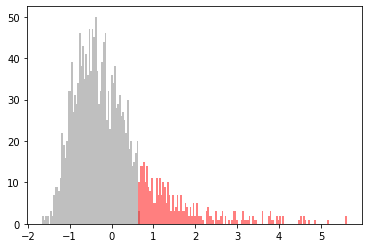

		genes processed: 1000
Gene BCL2L2: SNR=1.23, pos=1098, neg=806


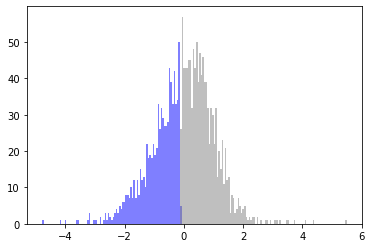

		genes processed: 2000
Gene CDK9: SNR=1.11, pos=892, neg=1012


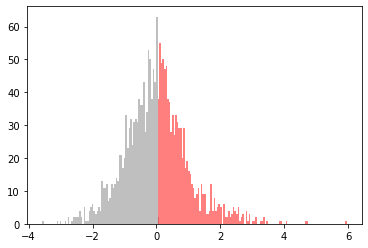

		genes processed: 3000
		genes processed: 4000
Gene ERBB2: SNR=1.84, pos=303, neg=1601


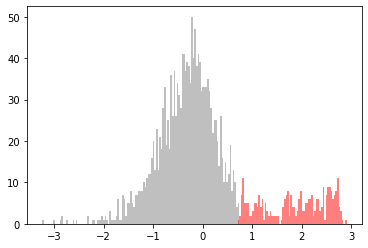

Gene ESR1: SNR=2.29, pos=1380, neg=524


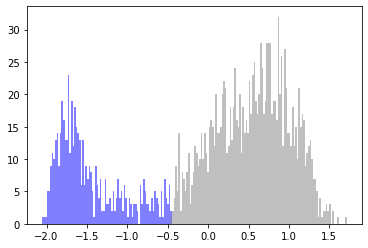

Gene FOXA1: SNR=3.25, pos=1667, neg=237


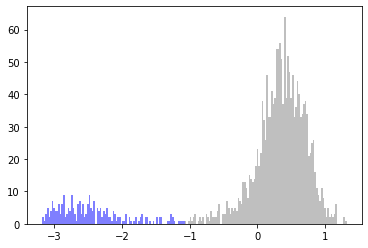

Gene GATA3: SNR=1.82, pos=1429, neg=475


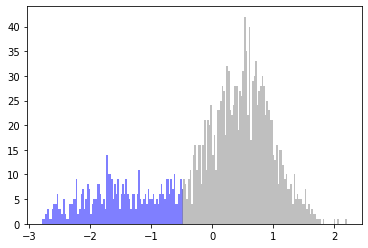

		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
Gene PIK3R2: SNR=1.24, pos=901, neg=1003


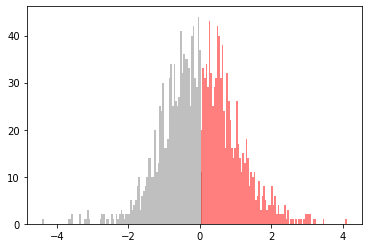

		genes processed: 10000
		genes processed: 11000
Gene SIRT6: SNR=1.18, pos=780, neg=1124


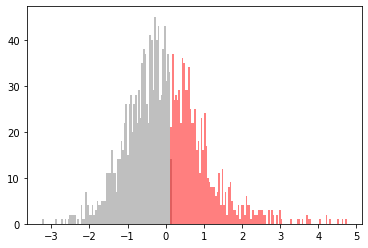

		genes processed: 12000
Gene SPOCK3: SNR=1.24, pos=952, neg=952


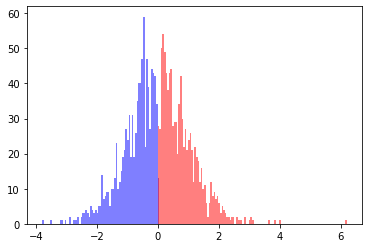

		genes processed: 13000
		genes processed: 14000
Gene ZNF415: SNR=1.31, pos=1301, neg=603


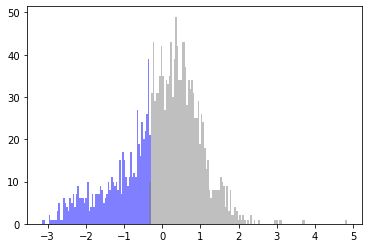

	Jenks binarization for 14986 features completed in 105.32 s
	binarization runtime: 1085.19 s
	1084 features passed binarization 
		UP-regulated features:	912
		DOWN-regulated features:	190
		ambiguous features:	18
Statistics is saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//METABRIC.seed_324678.Jenks.binarization_stats.tsv
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//METABRIC.seed_324678.Jenks.binarized_UP.tsv
Binarized gene expressions are saved to /home/olya/TUM/DESMOND/DESMOND2/tmp_results//METABRIC.seed_324678.Jenks.binarized_DOWN.tsv
time:	Initial state created in 3.4 s.
		LP memory, 6.35 M
		step  1 8.7 s
		step  2 4.0 s
		step  3 2.7 s
		step  4 2.1 s
		step  5 2.0 s
		step  6 1.5 s
		step  7 0.9 s
		step  8 0.9 s
		step  9 1.0 s
		step  10 1.0 s
		step  11 0.7 s
			features oscilating in the last 10 steps: 210
		step  12 0.8 s
			features oscilating in the last 10 steps: 84
		step  13 0.8 s
			features oscilating in the last 10 st

In [22]:
biclusters2 = run_DESMOND(exprs_file,basename,out_dir=out_dir,
                          bin_method="Jenks",clust_method="DESMOND")